# CyberDefend : URL Classifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install python-whois

     |████████████████████████████████| 91 kB 5.9 MB/s 
  Created wheel for python-whois: filename=python_whois-0.7.3-py3-none-any.whl size=87720 sha256=fee014f1d01a2c7b55e2c3e0486b84d89bf332885c002a15ca6ba752ed6b96fc
  Stored in directory: /root/.cache/pip/wheels/11/05/f7/895ce5a73665f77c8274a7d55e34fb3e6b4abbb9a7637e215b
Successfully built python-whois


In [3]:
# importing required packages for this section
import pickle
import pandas as pd
import numpy as np
import numpy
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse,urlencode, parse_qs
import ipaddress
import re
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request
from datetime import datetime
import requests
from collections import Counter
from math import log


In [4]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


Reading Extracted Features from the CSV files and Prepraing the Dataset

In [5]:
safe=pd.read_csv("/content/drive/MyDrive/Datasets/safe_Features_final.csv")
spam=pd.read_csv("/content/drive/MyDrive/Datasets/spam_Features_final.csv")
phish=pd.read_csv("/content/drive/MyDrive/Datasets/Phishing_Features_Final.csv")
malw=pd.read_csv("/content/drive/MyDrive/Datasets/Malware_Features_Final.csv")

In [6]:
phish.shape

(11500, 30)

In [7]:
spam.shape

(11999, 30)

In [8]:
malw.shape

(10003, 30)

In [9]:
safe.shape

(14999, 30)

In [10]:
df = pd.concat([safe,spam,phish,malw])


Exploratory Data Analysis

In [11]:
df.head()

,Unnamed: 0,havingIP,haveAtSign,countDot,prefixSuffix,redirection,httpDomain,tinyURL,getLength,getSlash,numDigit,numfragments,numsubdomain,domainExt,URL_Shannon_Entropy,Domain_Shannon_Entropy,Path_Shannon_Entropy,Query_Shannon_Entropy,QandP_Shannon_Entropy,Susp_ext,space preset,digitToLetter_ratio,Sp_Character,susp_words,num_Imag,domainAge,domainCountry,iframe,Mouse_Over,Label
0,0,0,0,2,1,0,0,0,22,0,0,0,0,com,3.788755,3.189898,0.000000,0.000000,-0.000000,0,0,0.000000,6,0,3.0,20.000000,AU,1,0,0
1,1,0,0,2,0,0,0,0,25,0,0,0,1,com,3.753270,3.175123,-0.000000,0.000000,1.000000,0,0,0.000000,6,0,0.0,0.999316,FR,0,0,0
2,2,0,0,2,0,0,0,0,28,0,0,0,0,com,3.940760,3.689704,0.000000,0.000000,-0.000000,0,0,0.000000,5,0,16.0,8.000000,US,1,0,0
3,3,0,0,2,0,0,0,0,28,0,0,0,1,org,3.815411,3.508695,-0.000000,0.000000,1.000000,0,0,0.000000,6,0,4.0,20.000000,US,1,0,0
4,4,0,0,2,0,0,0,0,62,1,10,0,1,com,4.706066,3.250000,2.321928,4.271371,4.509385,0,0,0.263158,14,1,0.0,28.002738,US,0,0,0


In [12]:
df.shape

(48501, 30)

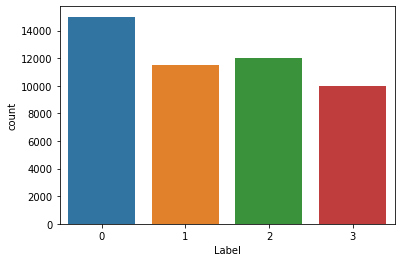

In [13]:
import seaborn as sns
sns.countplot(x=df['Label'])

In [14]:
df['httpDomain'].value_counts()

0    48491
1       10
Name: httpDomain, dtype: int64

Variance Analysis

In [15]:

df.var().sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


httpDomain                2.061431e-04
redirection               5.964001e-03
numfragments              6.582557e-03
haveAtSign                1.103022e-02
space preset              1.364365e-02
tinyURL                   4.577060e-02
prefixSuffix              8.821380e-02
iframe                    9.367374e-02
havingIP                  1.194337e-01
Domain_Shannon_Entropy    1.426443e-01
Mouse_Over                1.458381e-01
Susp_ext                  1.958421e-01
susp_words                2.150523e-01
URL_Shannon_Entropy       2.300324e-01
digitToLetter_ratio       4.780178e-01
Label                     1.258704e+00
QandP_Shannon_Entropy     2.395230e+00
countDot                  2.601959e+00
Path_Shannon_Entropy      2.737707e+00
getSlash                  2.824601e+00
Query_Shannon_Entropy     2.952528e+00
numsubdomain              3.265264e+00
Sp_Character              6.337488e+01
domainAge                 1.305092e+02
num_Imag                  4.309899e+02
numDigit                 

In [16]:
df.isnull().sum()

Unnamed: 0                    0
havingIP                      0
haveAtSign                    0
countDot                      0
prefixSuffix                  0
redirection                   0
httpDomain                    0
tinyURL                       0
getLength                     0
getSlash                      0
numDigit                      0
numfragments                  0
numsubdomain                  0
domainExt                   145
URL_Shannon_Entropy           0
Domain_Shannon_Entropy        0
Path_Shannon_Entropy          0
Query_Shannon_Entropy         0
QandP_Shannon_Entropy         0
Susp_ext                      0
space preset                  0
digitToLetter_ratio           0
Sp_Character                  0
susp_words                    0
num_Imag                   8570
domainAge                     0
domainCountry             12314
iframe                        0
Mouse_Over                    0
Label                         0
dtype: int64

In [17]:
df["domainCountry"].fillna("Originally NA", inplace = True)


In [18]:
df.groupby("Label")['num_Imag'].value_counts().nlargest(30).unstack(fill_value=0)

num_Imag,0.0,2.0,3.0,1.0,4.0,7.0,5.0,6.0,10.0,8.0,9.0,14.0,13.0,11.0,12.0,16.0,17.0,15.0
Label,,,,,,,,,,,,,,,,,,
0,4454,626,473,937,407,389,333,279,249,241,222,204,203,200,198,180,140,135
1,6466,755,233,1829,161,0,123,126,0,0,0,0,0,0,0,0,0,0
2,2609,1969,1886,836,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
df.groupby("Label")['num_Imag'].mean()

Label
0    11.573222
1     3.804214
2     2.660504
3     0.182915
Name: num_Imag, dtype: float64

In [20]:
medians = df.groupby("Label")['num_Imag'].transform('median')
medians

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
9998     0.0
9999     0.0
10000    0.0
10001    0.0
10002    0.0
Name: num_Imag, Length: 48501, dtype: float64

In [21]:
df['num_Imag'].fillna(medians,inplace=True)

In [22]:
df.groupby("Label")['num_Imag'].value_counts().nlargest(30).unstack(fill_value=0)

num_Imag,0.0,2.0,3.0,1.0,4.0,7.0,5.0,6.0,10.0,8.0,9.0,14.0,13.0,11.0,12.0,16.0,17.0,15.0
Label,,,,,,,,,,,,,,,,,,
0,4454,626,3365,937,407,389,333,279,249,241,222,204,203,200,198,180,140,135
1,7240,755,233,1829,161,0,123,126,0,0,0,0,0,0,0,0,0,0
2,2609,6071,1886,836,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9681,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df["tinyURL"].value_counts()

0    46169
1     2332
Name: tinyURL, dtype: int64

In [24]:
df = df.sample(frac=1,random_state=42).reset_index(drop=True)

In [25]:
#Finding non-numeric features features
num_cols = df._get_numeric_data().columns
cate_cols = list(set(df.columns)-set(num_cols))
cate_cols

['domainCountry', 'domainExt']

In [26]:
df['domainExt'].value_counts()[:20]


com     11882
html     5329
uk       2919
php      2656
m        2211
htm      1734
org      1620
a        1102
i         915
net       844
cn        549
edu       524
exe       513
sh        485
au        265
ru        249
io        225
ca        185
br        179
de        176
Name: domainExt, dtype: int64

In [27]:
# Grouping extensions based on labels (for analysis purpose)
df.groupby("Label")['domainExt'].value_counts().nlargest(30).unstack(fill_value=0)

domainExt,com,html,uk,m,php,org,a,htm,i,net,cn,exe,edu,sh,ru,io,au,br,ca,ly,in
Label,,,,,,,,,,,,,,,,,,,,,
0,7025,1671,634,0,0,1427,0,1089,0,562,0,0,491,0,0,0,181,0,158,0,0
1,4445,531,0,0,655,176,0,0,0,267,525,0,0,0,226,223,0,160,0,144,132
2,0,3127,2212,0,0,0,0,580,0,0,0,0,0,0,0,0,0,0,0,0,0
3,412,0,0,2211,1808,0,1102,0,915,0,0,511,0,481,0,0,0,0,0,0,0


In [28]:
df.groupby("Label")['domainCountry'].value_counts().nlargest(30).unstack(fill_value=0)

domainCountry,None,US,Originally NA,CA,IS,IN,GB,CN,BR,Malaysia,FR,JP,RU,CH,AU
Label,,,,,,,,,,,,,,,
0,1154,6306,4804,494,386,0,319,180,0,0,102,94,0,85,82
1,2096,3084,3213,137,493,378,116,297,218,187,0,0,91,0,0
2,8561,0,3438,0,0,0,0,0,0,0,0,0,0,0,0
3,6263,1808,859,0,135,147,0,133,0,0,0,0,0,0,0


In [29]:
len(df[(df.domainAge==0)])

18075

In [30]:
df['domainCountry'].value_counts()

None             18074
Originally NA    12314
US               11198
IS                1014
CA                 672
                 ...  
qa                   1
JM                   1
im                   1
CG                   1
GI                   1
Name: domainCountry, Length: 200, dtype: int64

In [31]:
# Common extensions observed for malcious links
ext=['m','a','i','sh','exe']
# Creating new feature for the same
df['hasMalwExt'] = [1 if x in ext else 0 for x in df['domainExt']]


# Similarly creating more features based on extension 
ext=['php']
df['hasPHPext'] = [1 if x in ext else 0 for x in df['domainExt']]

ext=['htm']
df['hasHTMext'] = [1 if x in ext else 0 for x in df['domainExt']]

ext=['html']
df['hasHTMLext'] = [1 if x in ext else 0 for x in df['domainExt']]


In [32]:
# df['countryNone'] = [1 if x == 'None' else 0 for x in df['domainCountry']]
# df['countryUS'] = [1 if x == 'US' else 0 for x in df['domainCountry']]
# df['countryBR'] = [1 if x == 'BR' else 0 for x in df['domainCountry']]



In [33]:
df1= df[ (df.Label == 0) | (df.Label == 1) | (df.Label == 3)]

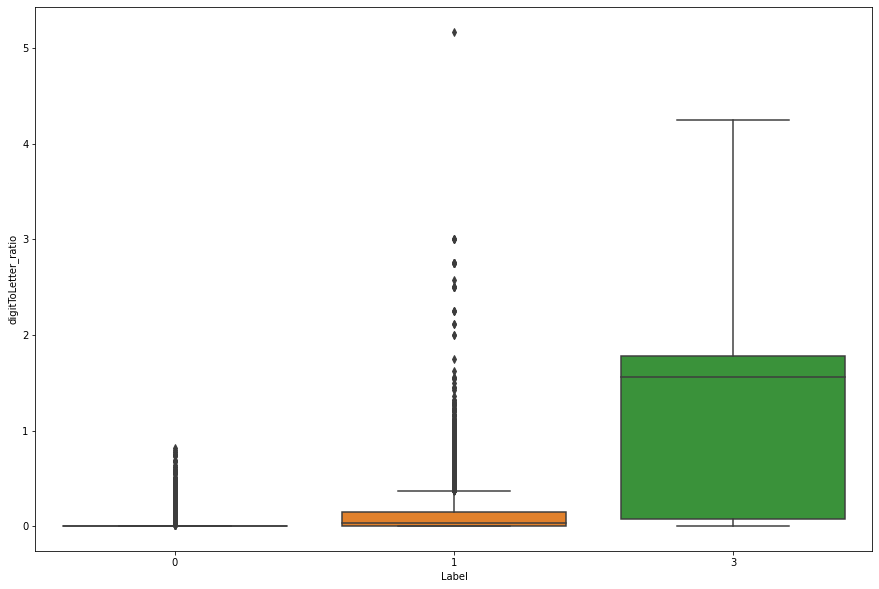

In [34]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['digitToLetter_ratio'],x=df1['Label'])

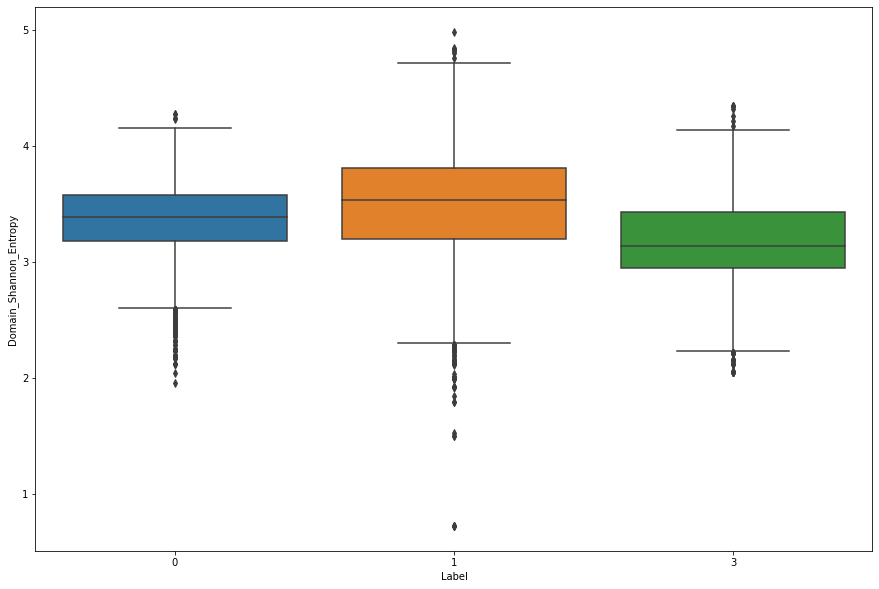

In [35]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['Domain_Shannon_Entropy'],x=df1['Label'])

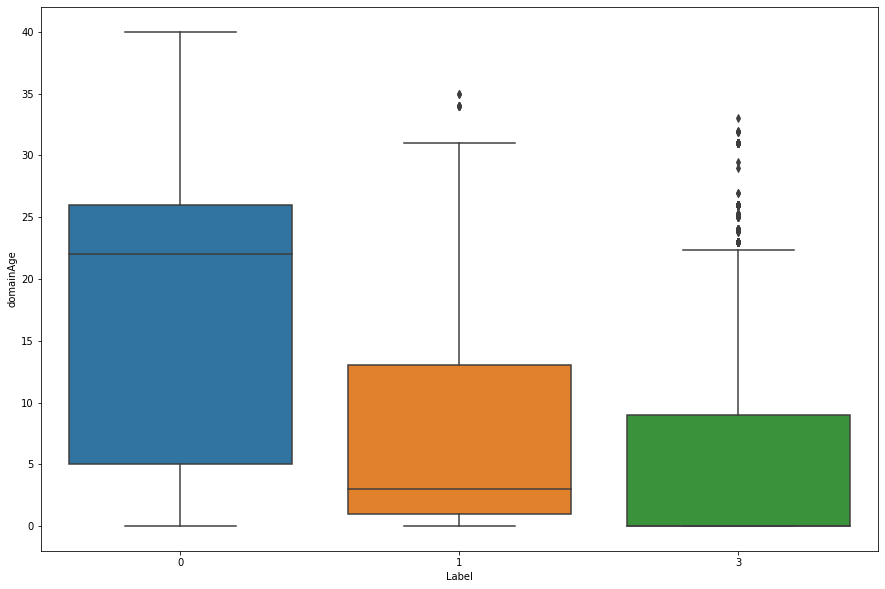

In [36]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['domainAge'],x=df1['Label'])

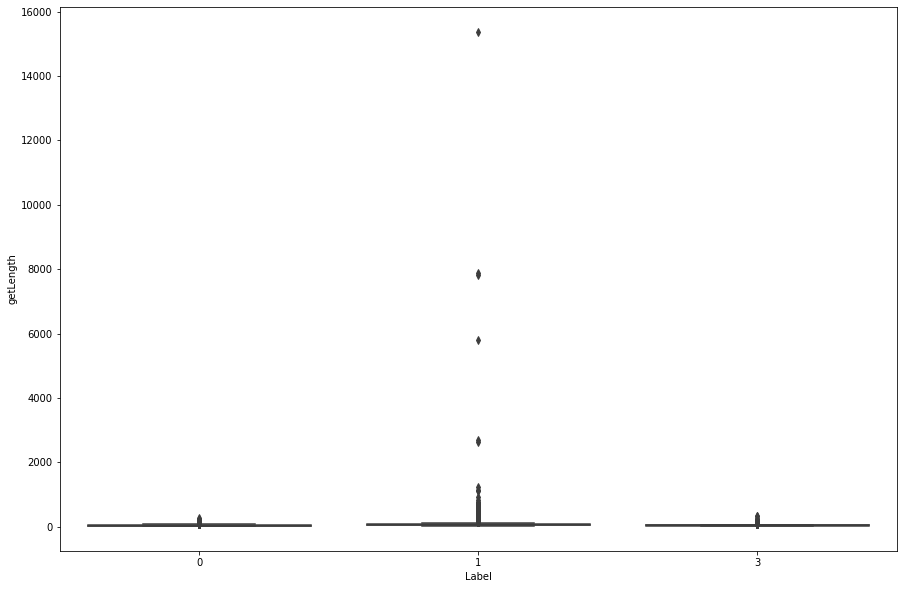

In [37]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['getLength'],x=df1['Label'])

In [38]:
print(df.shape[0])
df = df[(df.numDigit<500)]
print(df.shape[0])


48501
48494


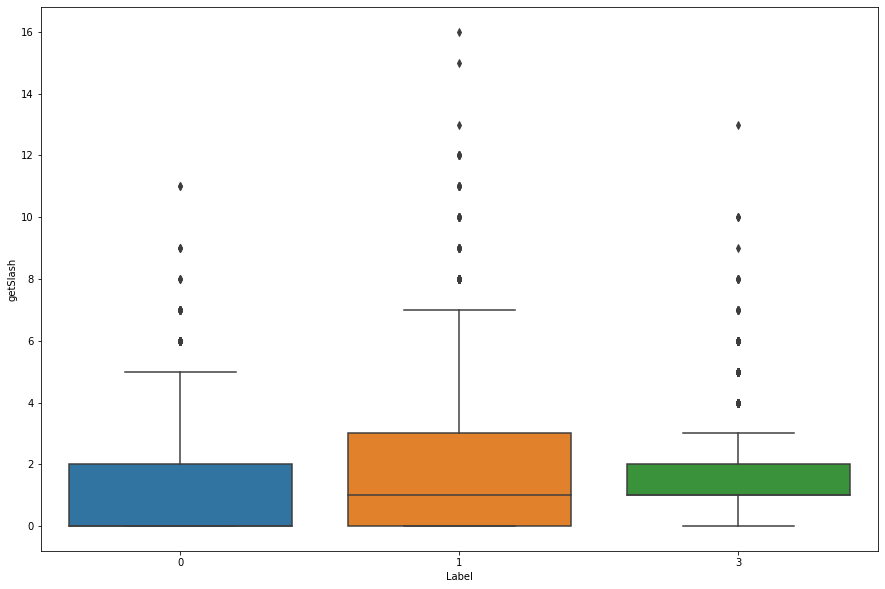

In [39]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['getSlash'],x=df1['Label'])

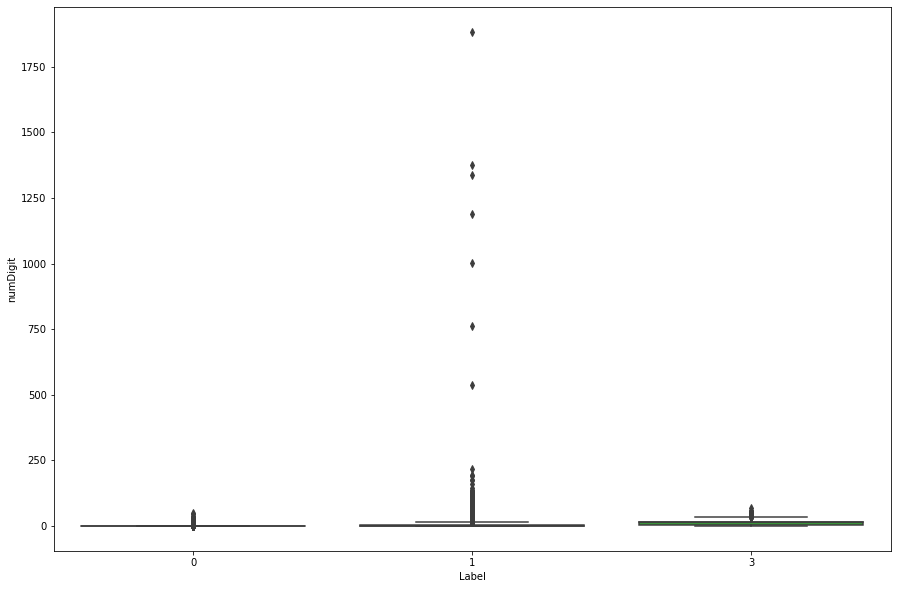

In [40]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['numDigit'],x=df1['Label'])

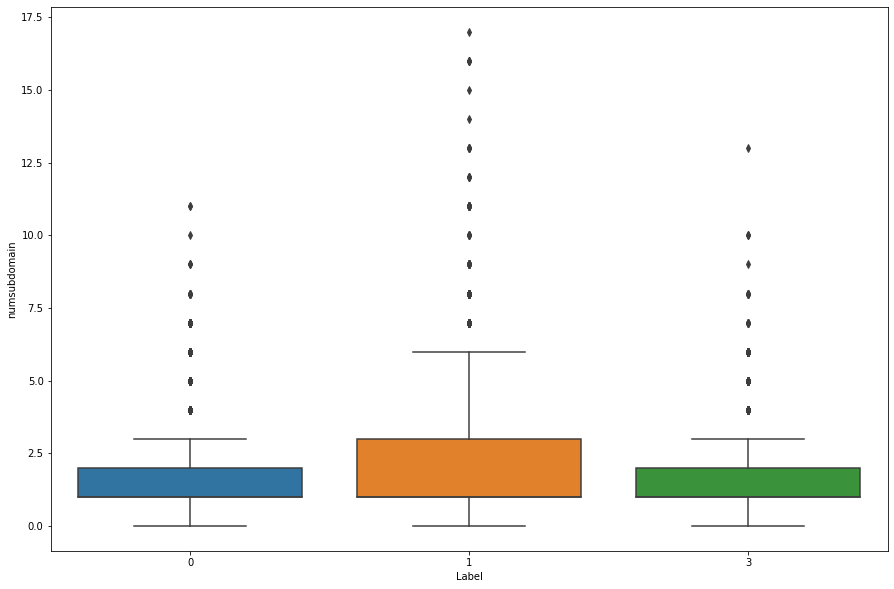

In [41]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['numsubdomain'],x=df1['Label'])

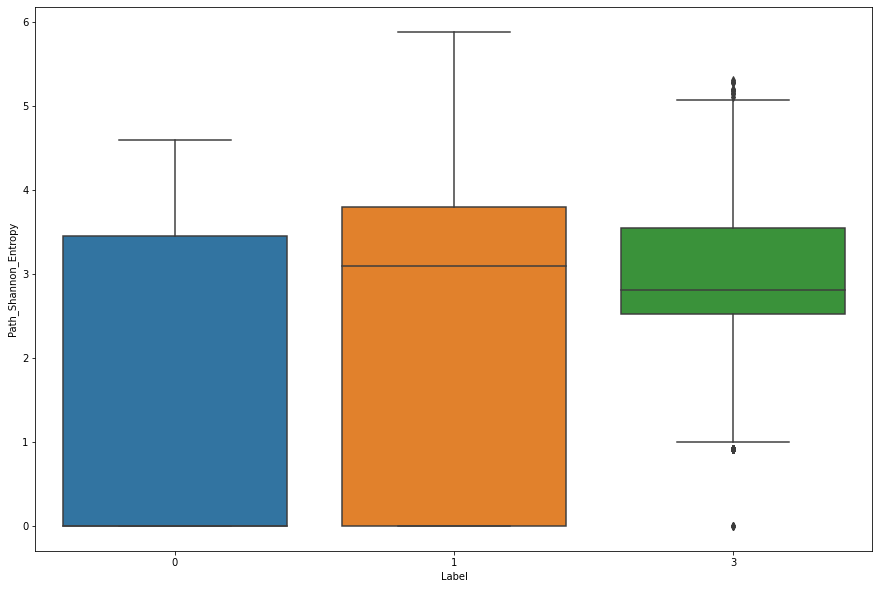

In [42]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['Path_Shannon_Entropy'],x=df1['Label'])

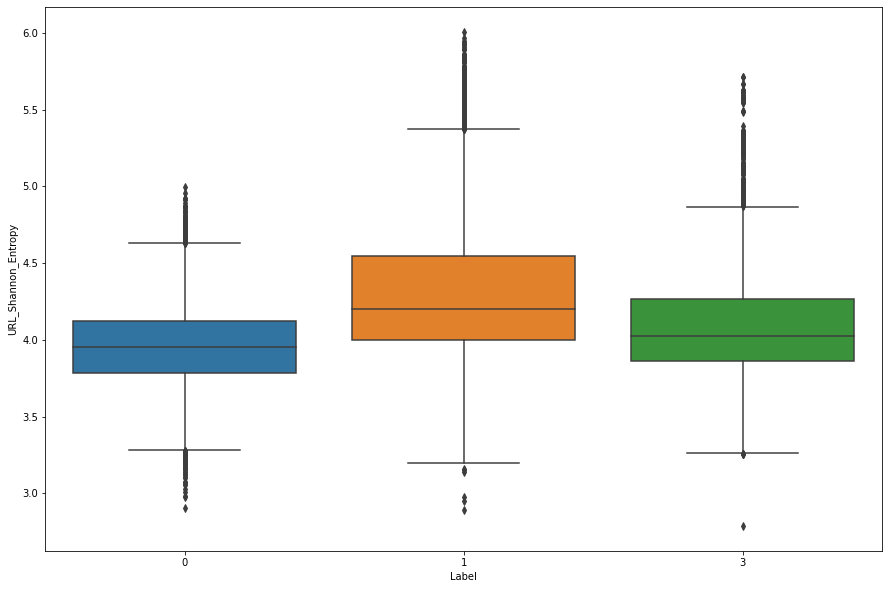

In [43]:
plt.figure(figsize=(15,10))
sns.boxplot(y=df1['URL_Shannon_Entropy'],x=df1['Label'])

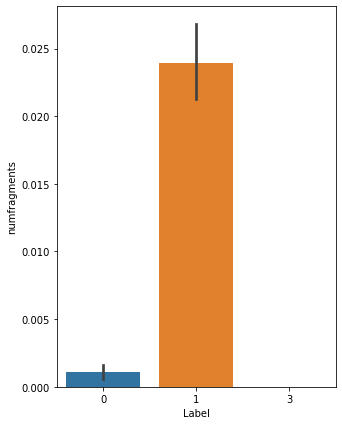

In [44]:
plt.figure(figsize=(5,7))
sns.barplot(y=df1['numfragments'],x=df1['Label'])

In [45]:
df.columns

Index(['Unnamed: 0', 'havingIP', 'haveAtSign', 'countDot', 'prefixSuffix',
       'redirection', 'httpDomain', 'tinyURL', 'getLength', 'getSlash',
       'numDigit', 'numfragments', 'numsubdomain', 'domainExt',
       'URL_Shannon_Entropy', 'Domain_Shannon_Entropy', 'Path_Shannon_Entropy',
       'Query_Shannon_Entropy', 'QandP_Shannon_Entropy', 'Susp_ext',
       'space preset', 'digitToLetter_ratio', 'Sp_Character', 'susp_words',
       'num_Imag', 'domainAge', 'domainCountry', 'iframe', 'Mouse_Over',
       'Label', 'hasMalwExt', 'hasPHPext', 'hasHTMext', 'hasHTMLext'],
      dtype='object')

Preparing the Input

In [46]:
feature_names = ['havingIP', 'haveAtSign', 'countDot', 'prefixSuffix',
        'tinyURL', 'getLength', 'getSlash',
       'numDigit','numsubdomain', 
       'URL_Shannon_Entropy', 'Domain_Shannon_Entropy', 'Path_Shannon_Entropy',
       'Query_Shannon_Entropy', 'QandP_Shannon_Entropy',
        'digitToLetter_ratio', 'Sp_Character', 'susp_words',
       'num_Imag', 'iframe', 'Mouse_Over', 'hasMalwExt','hasHTMext','hasHTMLext', 'hasPHPext',
]

# 
# 'hasPhishExt', 'hasPHPext',
#        'hasCOM', 'hasNET',  'hasORGext', 'hasUKext',  'countryNone', 'countryUS','countryBR', 'Susp_ext',       
# 

# feature_names1 = ['havingIP', 'haveAtSign', 'countDot', 'prefixSuffix', 
#                  'redirection','tinyURL', 'getLength', 'getSlash','numDigit','numsubdomain',
#                  'URL_Shannon_Entropy','Domain_Shannon_Entropy','Path_Shannon_Entropy','Query_Shannon_Entropy',
#                  'QandP_Shannon_Entropy','Susp_ext','digitToLetter_ratio','Sp_Character','susp_words',
#                  'num_Imag','domainAge','iframe', 'Mouse_Over','hasHTMext','hasPHPext','hasPhishExt','hasMalwExt','hasCOM','hasORGext',
#                  'hasHTMLext','hasUKext','countryNone','countryUS','hasNET']

# print(set(feature_names).difference(set(feature_names1)))

sc = MinMaxScaler()

X=df[feature_names]
X = pd.DataFrame(sc.fit_transform(X))
# Y=df["Label"].values.reshape(-1, 1,). astype(int)
y=df["Label"]
from pickle import dump
dump(sc, open('scaler.pkl', 'wb'))

In [47]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,0.047619,0.0,0.0,0.014184,0.0625,0.067797,0.029412,0.379016,0.618395,0.477213,0.000000,0.500526,0.418301,0.040,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.031746,0.0,0.0,0.200000,0.1250,0.169492,0.058824,0.864552,0.676416,0.550570,0.905593,0.919319,0.038259,0.048,1.0,0.001522,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.015873,0.0,0.0,0.008511,0.0625,0.000000,0.058824,0.274956,0.606927,0.382747,0.000000,0.420716,0.000000,0.024,0.0,0.013699,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.031746,0.0,0.0,0.036170,0.3125,0.012712,0.147059,0.573759,0.698598,0.759623,0.000000,0.755158,0.014406,0.072,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.015873,1.0,0.0,0.022695,0.1875,0.000000,0.088235,0.444165,0.751895,0.639535,0.000000,0.643241,0.000000,0.040,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
len(feature_names)

24

In [49]:
y.value_counts()

0    14999
2    11999
1    11493
3    10003
Name: Label, dtype: int64

In [50]:
# from keras.utils.np_utils import to_categorical
# y_cat = to_categorical(Y)
# y_cat

In [51]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [52]:
y_train.value_counts()

0    12011
2     9584
1     9183
3     8017
Name: Label, dtype: int64

Training and tuning ML models

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='not majority',k_neighbors=25)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# from imblearn.over_sampling import ADASYN
# ada=ADASYN(sampling_strategy='not majority',random_state=130,n_neighbors=10)
# X_train,y_train=ada.fit_resample(X_train,y_train)

# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42,sampling_strategy={0:12030,1:12030,2:12030,3:12030})
# X_train,y_train=ros.fit_resample(X_train,y_train)


# from imblearn.under_sampling import NearMiss
# nr = NearMiss()
# X_train,y_train=nr.fit_resample(X_train,y_train)

y_train.value_counts()

0    12011
2     9584
1     9183
3     8017
Name: Label, dtype: int64

Random Forest model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
     'n_estimators': [100, 200,300,400],
    'min_samples_leaf': [1,2,4,8],
    'min_samples_split': [2,4,6,8,10]
   
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid = param_grid,scoring='accuracy',random_state=42, cv = 3, n_jobs = -1, verbose = 2,)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(min_samples_leaf= 1, min_samples_split= 2, n_estimators= 400,random_state=42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred

array([2, 2, 3, ..., 2, 2, 2])

In [ ]:

from sklearn.metrics import classification_report
ypred = clf.predict(X_test)
print(classification_report(ypred, y_test,digits=4))

              precision    recall  f1-score   support

           0     0.9341    0.9226    0.9283      3025
           1     0.9000    0.8950    0.8975      2323
           2     0.9905    0.9963    0.9934      2401
           3     0.9678    0.9856    0.9766      1950

    accuracy                         0.9469      9699
   macro avg     0.9481    0.9499    0.9489      9699
weighted avg     0.9466    0.9469    0.9467      9699



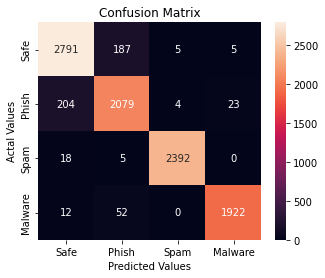

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Safe', 'Phish','Spam','Malware'], 
                     columns = ['Safe', 'Phish','Spam','Malware'])
plt.figure(figsize=(5,4))
plt.ticklabel_format(style='plain', axis='y',)

sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

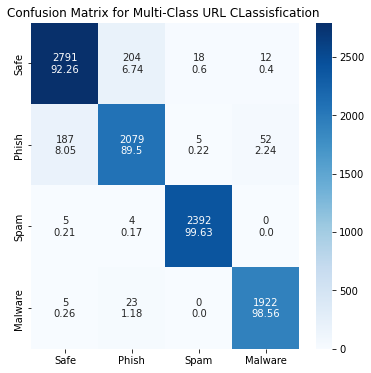

In [ ]:
cf_matrix = confusion_matrix(ypred, y_test)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages=[]
for i in range(0,4):
  a=(cf_matrix[i] / np.sum(cf_matrix[i]))*100
  #avg=["{0:.2%}".format(value) for value in a]
  for val in a:
    val=round(val,2)
    group_percentages.append(val)
 
labels = [
        f"{v2}\n{v3}"
        for  v2, v3 in zip(group_counts, group_percentages)
    ]
labels = np.asarray(labels).reshape(4, 4)
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for Multi-Class URL CLassisfication ")
x_axis_labels=['Safe', 'Phish','Spam','Malware']
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues",xticklabels=x_axis_labels, yticklabels=x_axis_labels)

In [ ]:
plt.figure(figsize=(10,9))
plt.barh(feature_names, clf.feature_importances_)


In [ ]:
pickle.dump(clf, open("rf.dat", "wb"))
clf2 = pickle.load(open("rf.dat", "rb"))
from sklearn.metrics import classification_report
ypred = clf2.predict(X_test)
print(classification_report(ypred, y_test,digits=4))

              precision    recall  f1-score   support

           0     0.9341    0.9226    0.9283      3025
           1     0.9000    0.8950    0.8975      2323
           2     0.9905    0.9963    0.9934      2401
           3     0.9678    0.9856    0.9766      1950

    accuracy                         0.9469      9699
   macro avg     0.9481    0.9499    0.9489      9699
weighted avg     0.9466    0.9469    0.9467      9699



XGBoost model

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
params = { 'max_depth': [6,10,20,30],
          'n_estimators': [500,1000, 2000],
           'learning_rate': [0.01]
          #  'subsample': [0.5,0.7],
          #  'colsample_bytree': [0.4,0.6],
          #  'colsample_bylevel': [0.4,0.6,0.8],
           }

grid_search = GridSearchCV(estimator=xgb,param_grid=params,cv=3, verbose=2, n_jobs=-1,scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
from xgboost import XGBClassifier
xgb= XGBClassifier(learning_rate= 0.01,n_estimators=2000,max_depth= 8)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test,digits=4))

              precision    recall  f1-score   support

           0     0.9321    0.9152    0.9236      3043
           1     0.8848    0.8996    0.8922      2272
           2     0.9938    0.9950    0.9944      2412
           3     0.9728    0.9797    0.9763      1972

    accuracy                         0.9445      9699
   macro avg     0.9459    0.9474    0.9466      9699
weighted avg     0.9446    0.9445    0.9445      9699



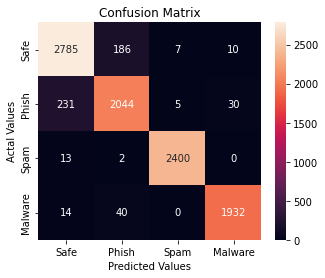

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Safe', 'Phish','Spam','Malware'], 
                     columns = ['Safe', 'Phish','Spam','Malware'])
plt.figure(figsize=(5,4))
plt.ticklabel_format(style='plain', axis='y',)

sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

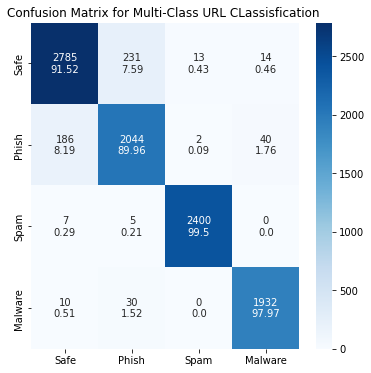

In [ ]:
cf_matrix = confusion_matrix(y_pred, y_test)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages=[]
for i in range(0,4):
  a=(cf_matrix[i] / np.sum(cf_matrix[i]))*100
  #avg=["{0:.2%}".format(value) for value in a]
  for val in a:
    val=round(val,2)
    group_percentages.append(val)
 
labels = [
        f"{v2}\n{v3}"
        for  v2, v3 in zip(group_counts, group_percentages)
    ]
labels = np.asarray(labels).reshape(4, 4)
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix for Multi-Class URL CLassisfication ")
x_axis_labels=['Safe', 'Phish','Spam','Malware']
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues",xticklabels=x_axis_labels, yticklabels=x_axis_labels)

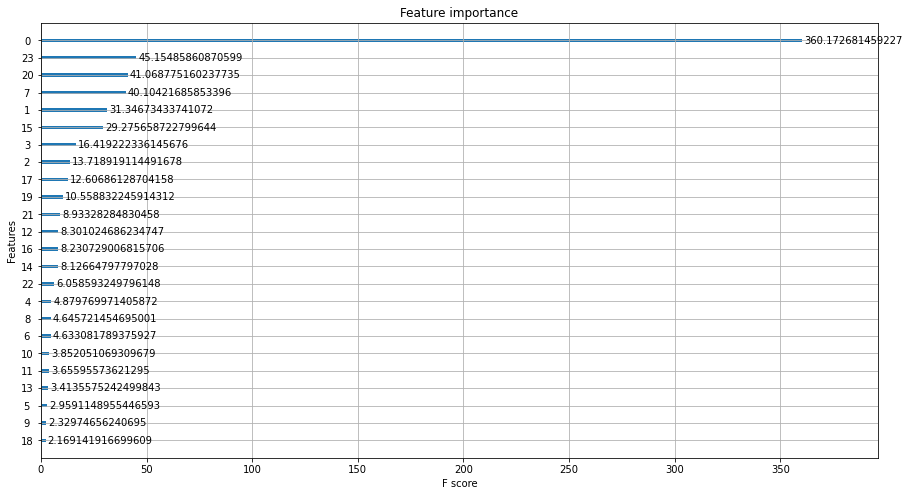

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15, 8))

plot_importance(xgb,ax=ax,importance_type='gain')

plt.show()

In [ ]:
# from catboost import CatBoostClassifier
# cat = CatBoostClassifier()


# params = { 'n_estimators': [500,1000, 2000],
#             'max_depth': [6,10,20,30],
#            'learning_rate': [0.01]
#            }

# grid_search = GridSearchCV(estimator=cat,param_grid=params,cv=3, verbose=2, n_jobs=-1,scoring='accuracy')
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [ ]:
# !pip install catboost


# # train the model on train set
# model = CatBoostClassifier(learning_rate=0.1,n_estimators= 100,max_depth=16)
# model.fit(X_train, y_train,verbose=0)
 



In [ ]:
# # print prediction results
# predictions = model.predict(X_test)
# print(classification_report(y_test, predictions,digits=4))

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

ada = AdaBoostClassifier()


params = {
           'learning_rate': [1,1.1],

           'n_estimators': [200,500,1000,2000]}

grid_search = GridSearchCV(estimator=ada,param_grid=params,cv=3, verbose=2, n_jobs=-1,scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'learning_rate': 1.1, 'n_estimators': 500}

In [56]:
from sklearn.metrics import classification_report

abc = AdaBoostClassifier(n_estimators=500,learning_rate=1.1)
model = abc.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.7583    0.8317    0.7933      2988
           1     0.7139    0.6545    0.6829      2310
           2     0.8576    0.7979    0.8267      2415
           3     0.8381    0.8681    0.8528      1986

    accuracy                         0.7885      9699
   macro avg     0.7920    0.7881    0.7889      9699
weighted avg     0.7888    0.7885    0.7875      9699



Feature Extraction

In [ ]:
#check for IP in URL domain
def havingIP(url):
    regex=re.compile('.*\d+\.\d+\.\d+\.\d+\.*')
    d=regex.match(url)
    if d==None:
        return 0
    else:
        return 1

def haveAtSign(url):
  if "@" in url:
    at = 1    
  else:
    at = 0    
  return at

# count number of dots
def countDot(url):
  return url.count('.')

def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            # phishing
    else:
        return 0
# Checking for redirection '//' in the url (Redirection)
def redirection(url):
  pos = url.rfind('//')
  if pos < 8:
      return 0
  else:
    return 1

# Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0
# Calculating domain length 
def domain_length(url):
    domain = urlparse(url).netloc
    return(len(domain))

# Calculating path length
# def path_length(url):
#     path = urlparse(url).path
#     return(len(path))

# Function for calcuating Shannon Entropy of a string
def shannon_entropy(string):
    counts = Counter(string)
    frequencies = ((i / len(string)) for i in counts.values())
    return - sum(f * log(f, 2) for f in frequencies)

# Calculating Shannon Entropy of URL
def url_shannon_entropy(url):
    return shannon_entropy(url)

# Calculating Shannon Entropy of Domain
def domain_shannon_entropy(url):
    domain = urlparse(url).netloc
    return shannon_entropy(domain)

# Calculating Shannon Entropy of Path
def path_shannon_entropy(url):
    path = urlparse(url).path
    return shannon_entropy(path)

# Calculating Shannon Entropy of Query
def query_shannon_entropy(url):
    query= urlparse(url).query
    return shannon_entropy(query)

# Calculating Shannon Entropy of Path+Query
def query_path_shannon_entropy(url):
    pathquery= urlparse(url).path+'?'+urlparse(url).query
    return shannon_entropy(pathquery)

# Check if dangerous extension is present in the URL
# Reference : https://www.howtogeek.com/137270/50-file-extensions-that-are-potentially-dangerous-on-windows/
# Ref : https://sensorstechforum.com/popular-windows-file-types-used-malware-2018/
def suspiciousExtension(url):
    dangerous_extensions=['.exe','.pif','.application','.gadget',
                          '.msi','.msp','.scr','.hta','.cpl','.msc','.jar',
                         '.bat','.cmd','.vb','.vbs','.vbe','.js','.jse'
                         ,'.ws','.wsf','.wsc','.wsh','.ps1','.ps1xml','.ps2'
                         ,'.ps2xml','.psc1','.psc2','.msh','.scf','.lnk',
                         '.inf','.reg','htm','.hta','.sfx','.dll','.tmp','.py']
    for extension in dangerous_extensions:
        if re.search(extension,url):
            return 1
    return 0


# Checking if %20 percent in the URL
def spacePresent(url):
    if re.search('%20',url):
        return 1
    else:
        return 0


# Count number of special characters in the URL
def specialCharacters(url): 
    special_char= 0
    for c in url:
        if (c.isalpha()): 
            continue
        elif (c.isdigit()):
            continue
        else: 
            special_char += 1
    return special_char

# Check if suspicious words - (security sensitive words/ brand names) present in the URL
# Reference to list of words: Tupsamudre H., Singh A.K., Lodha S. (2019) Everything Is in the Name – A URL Based Approach for Phishing Detection. In: Dolev S., Hendler D., Lodha S., Yung M. (eds) Cyber Security Cryptography and Machine Learning. CSCML 2019. Lecture Notes in Computer Science, vol 11527. Springer, Cham. https://doi.org/10.1007/978-3-030-20951-3_21
def suspiciousWords(url):
    
    suspicious_words=['paypal','ali','safety','verify','google','netflix','instagram',
                     'icici','hdfc', 'apple','facebook','amazon','porn','gamble',
                      'award','limited','securewebsession','confirmation',
                    'signin','protection','access','redirectme','secure',
                      'recovery', 'verify','limited','secure',
     'web',
     'session',
     'confirmation',
     'page',
     'sign',
     'team',
     'access',
     'protection',
     'active',
     'manage',
     'redirectme',
     'secure',
     'customer',
     'account',
     'client',
     'information',
     'recovery',
     'verify',
     'secured',
     'business',
     'refund',
     'help',
     'safe',
     'bank',
     'event',
     'promo',
     'webservis',
     'giveaway',
     'card',
     'webspace',
     'user',
     'notify',
     'servico',
     'store',
     'device',
     'payment',
     'webnode',
     'drive',
     'shop',
     'gold',
     'violation',
     'random',
     'upgrade',
     'webapp',
     'dispute',
     'setting',
     'banking',
     'activity',
     'startup',
     'review',
     'email',
     'approval',
     'admin',
     'browser',
     'billing',
     'advert',
     'protect',
     'case',
     'temporary',
     'alert',
     'portal',
     'login',
     'servehttp',
     'center',
     'client',
     'restore',
     'secure',
     'blob',
     'smart',
     'fortune',
     'gift',
     'server',
     'security',
     'page',
     'confirm',
     'notification',
     'core',
     'host',
     'central',
     'service',
     'account',
     'servise',
     'support',
     'apps',
     'form',
     'info',
     'compute',
     'verification',
     'check',
     'storage',
     'setting',
     'digital',
     'update',
     'token',
     'required',
     'resolution',
     'ebay',
     'webscr',
     'free',
     'lucky',
     'bonus']
    
    for word in suspicious_words:
        if re.search(word,url):
            return 1
    return 0

# Get number of images 
def imgCount(url):
    try:
        response = requests.get(url,timeout=5)
        soup = BeautifulSoup(response.content)
    except:
        return 0
    return len(soup.find_all('img'))

#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"


#Checking for Shortening Services in URL (Tiny_URL)
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
      return 1
    else:
        return 0

# Finding the length of URL and categorizing (URL_Length)
def getLength(url):         
  return len(url)


# number of '/' in URL 
def getSlash(url):
  s = urlparse(url).path.split('/')
  count = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      count += 1
  return count

def numDigits(url):
        digits = [i for i in url if i.isdigit()]
        return len(digits)


def numParameters(url):
        params = url.split('&')
        return len(params) - 1

def numFragments(url):
        fragments = url.split('#')
        return len(fragments) - 1

def numSubDomains(url):
        subdomains = url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

def domainExtension(url):
        ext = url.split('.')[-1].split('/')[0]
        return ext

def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
     # print("hi1")
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      #print("hi2")
      return 1
  elif ((type(expiration_date) is list) and (type(creation_date) is list)):
        ageofdomain = abs((expiration_date[0] - creation_date[0]).days)
  elif (type(creation_date) is list):
        ageofdomain = abs((expiration_date - creation_date[0]).days)
  elif  (type(expiration_date) is list):
        ageofdomain = abs((expiration_date[0] - creation_date).days)
  else:
        ageofdomain = abs((expiration_date - creation_date).days)
  #print(ageofdomain/365.25)
  #print("hi3")
  #if ((ageofdomain/365.25) < 2):
  #    age = 1
  #else:
  #    age = 0
  return (ageofdomain/365.25)

def country(domain_name):
  return domain_name.country
def iframe(response):
  if response == "":
      return 0
  else:
      #print()
      if "<iframe " in response.text or 'frameBorder="0"' in response.text:
          return 1
      else:
          return 0
def mouseOver(response): 
  if response == "" :
    return 1
  else:
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0


def hasMalwExt(url):
  print('url:',url)
  domainextension=domainExtension(url)
  print('dom- ',domainextension)
  ext=['m','a','i','sh','exe']
  if domainextension in ext:
    return 1
  return 0

def hasPHPext(url):
  domainextension=domainExtension(url)
  ext=['php']

  if domainextension in ext:
    return 1
  else:
    return 0

def hasHTMext(url):
  domainextension=domainExtension(url)
  ext=['htm']

  if domainextension in ext:
    return 1
  else:
    return 0

def hasHTMLext(url):
  domainextension=domainExtension(url)
  ext=['html']

  if domainextension in ext:
    return 1
  else:
    return 0

# Calculating Digit to Letter ratio
def digitToLetterRatio(url):
    d=0
    l=0
    for c in url:
        if c.isdigit():
            d=d+1
        elif c.isalpha():
            l=l+1
        else:
            pass
    
    return(d/l)


def featureExtraction(urllis):
  dns=0
  featureslis=[]
  for url in urllis:
    print('url list-',url)
    features = []
    features.append(havingIP(url))
    features.append(haveAtSign(url))
    features.append(countDot(url))
    features.append(prefixSuffix(url))
    #features.append(redirection(url))
    #features.append(httpDomain(url))
    features.append(tinyURL(url))
    features.append(getLength(url))
    features.append(getSlash(url))
    features.append(numDigits(url))
    #features.append(numFragments(url))
    features.append(numSubDomains(url))
    #features.append(domainExtension(url))

    features.append(url_shannon_entropy(url))
    features.append(domain_shannon_entropy(url))
    features.append(path_shannon_entropy(url))
    features.append(query_shannon_entropy(url))
    features.append(query_path_shannon_entropy(url))
    #features.append(suspiciousExtension(url))
    #features.append(spacePresent(url))
    features.append(digitToLetterRatio(url))
    features.append(specialCharacters(url))
    features.append(suspiciousWords(url))

    
    features.append(imgCount(url))
   
    
  # HTML & Javascript based features (4)
    try:
      response = requests.get(url,timeout=5)
    except:
      response = ""
    features.append(iframe(response))
    features.append(mouseOver(response))
    features.append(hasMalwExt(url))
    features.append(hasHTMext(url))
    features.append(hasHTMLext(url))
    features.append(hasPHPext(url))
    #features.append(hasCOM('url'))
    #features.append(hasNET('url'))
    #features.append(hasIOext('url'))


    #features=pd.DataFrame(features,dtype='float32')
    #features=np.nan_to_num(features)
    #features=features.tolist()
    
    featureslis.append(features)
    print(featureslis)
    frame=pd.DataFrame(sc.transform(featureslis))
    print(frame)
  return frame

In [ ]:
# def prediction (url):
#   label=['Safe','Phishing','Spam','Malware']
#   feat=featureExtraction(url)
#   #print(X_test.iloc[:3,:])
#   y_pred_prob = clf2.predict(feat) 
#   y_pred = y_pred_prob.argmax(axis=-1)
#   #print(y_pred_prob)
#   print('ypre=',y_pred)


#   res=[]
#   for i in list(y_pred):
#     res.append(label[i])
#   return label[y_pred]
def prediction (url):
  label=['Safe','Phishing','Spam','Malware']
  feat=featureExtraction(url)
  y_pred_prob = clf2.predict(feat) 
  print(y_pred_prob)
  res=[]
  for i in y_pred_prob:
    res.append(label[i])
  return res

In [ ]:

model.save("URL_Classifier_Iteration_2.h5")


In [ ]:
from pickle import dump
dump(sc, open('scaler.pkl', 'wb'))

In [ ]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 38.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
